In [1]:
import os
import json
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import tensorly as ts
from scipy import stats
from scipy.spatial import distance

In [2]:
# The manipulation and extraction procedures of the .json files obtained from Sonar output is copied from
# https://github.com/fga-eps-mds/Analytics, developed by Gabriel Filipe Manso in context of teacher assistant activities
# in EPS and MDS courses in 2020.2 academic period, under supervising by prof. Hilmer R. Neri in University of Brazilia,
# Faculty of Gama- Software Engineering graduate course.
# https://github.com/fga-eps-mds/A-Disciplina-MDS-EPS/blob/master/PlanosDeEnsino/EPS-cronograma-2020-2-hrn.md
# https://github.com/fga-eps-mds/A-Disciplina-MDS-EPS/blob/master/PlanosDeEnsino/MDS-cronograma-hrn.md
from scipy.stats import mannwhitneyu

%config InlineBackend.figure_format ='retina'

sns.set(font_scale=1.5)

sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [4]:
jsons = glob('siged-raw-data-08-05-2021/*.json')

In [5]:
jsons

['siged-raw-data-08-05-2021/fga-eps-mds-2020-2-SiGeD-Sectors-date_v1.0.json',
 'siged-raw-data-08-05-2021/fga-eps-mds-2020-2-SiGeD-Frontend-date_v0.10.2.json',
 'siged-raw-data-08-05-2021/fga-eps-mds-2020-2-SiGeD-Demands-date_v1.3.0.json',
 'siged-raw-data-08-05-2021/fga-eps-mds-2020-2-SiGeD-Frontend-date_v0.7.json',
 'siged-raw-data-08-05-2021/fga-eps-mds-2020-2-SiGeD-Frontend-date_v1.9.1.json',
 'siged-raw-data-08-05-2021/fga-eps-mds-2020-2-SiGeD-Frontend-date_v1.5.1.json',
 'siged-raw-data-08-05-2021/fga-eps-mds-2020-2-SiGeD-Users-date_v1.0.1.json',
 'siged-raw-data-08-05-2021/fga-eps-mds-2020-2-SiGeD-Demands-date_v0.1.json',
 'siged-raw-data-08-05-2021/fga-eps-mds-2020-2-SiGeD-Frontend-date_v1.7.0.json',
 'siged-raw-data-08-05-2021/fga-eps-mds-2020-2-SiGeD-Frontend-date_v1.7.1.json',
 'siged-raw-data-08-05-2021/fga-eps-mds-2020-2-SiGeD-Users-date_v1.0.0.json',
 'siged-raw-data-08-05-2021/fga-eps-mds-2020-2-SiGeD-Frontend-date_v1.5.0.json',
 'siged-raw-data-08-05-2021/fga-eps-mds-20

In [6]:
def read_json(json_path):

    with open(json_path) as json_file:
        json_obj = json.load(json_file)

    return json_obj

In [7]:
def create_base_component_df(json_list):

    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)

    aux_df = df['filename'].str.split(r"SiGeD-(.*?)-date_(.*?).json", expand=True)

    df['repository'] = aux_df[1]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [8]:
base_component_df = create_base_component_df(jsons)

In [9]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
576,files,8,NaN,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.0.json,Clients,V1.0.0
577,ncloc,413,NaN,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.0.json,Clients,V1.0.0
578,functions,32,NaN,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.0.json,Clients,V1.0.0
579,complexity,45,NaN,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.0.json,Clients,V1.0.0
580,security_rating,1.0,True,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.0.json,Clients,V1.0.0
581,reliability_rating,1.0,True,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.0.json,Clients,V1.0.0
582,comment_lines_density,0.0,False,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.0.json,Clients,V1.0.0
583,duplicated_lines_density,0.0,True,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.0.json,Clients,V1.0.0
552,files,8,NaN,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.1.json,Clients,V1.0.1
553,ncloc,483,NaN,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.1.json,Clients,V1.0.1


In [10]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [11]:
def metric_per_file(json):

    file_json = []

    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)

    return file_json

In [12]:
def generate_file_dataframe(metric_list, json, language_extension):

    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)

    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass

    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

In [13]:
def create_file_df(json_list):

    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)

        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe(metric_list, file_component_data, language_extension = 'js')

        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)

    aux_df = df['filename'].str.split(r"SiGeD-(.*?)-date_(.*?).json", expand=True)

    df['repository'] = aux_df[1]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [14]:
file_component_df = create_file_df(jsons)

file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
4288,tests/api.test.js,8,8,0.0,0.0,NaN,120,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.0.json,Clients,V1.0.0
4289,src/Controllers/ClientController.js,6,11,0.0,0.0,NaN,91,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.0.json,Clients,V1.0.0
4290,src/Models/ClientSchema.js,0,0,0.0,0.0,NaN,51,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.0.json,Clients,V1.0.0
4291,src/utils/functionsJWS.js,2,4,0.0,0.0,NaN,16,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.0.json,Clients,V1.0.0
4292,src/index.js,3,3,0.0,0.0,NaN,28,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.0.json,Clients,V1.0.0
4293,scripts/release.js,7,8,0.0,0.0,NaN,61,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.0.json,Clients,V1.0.0
4294,src/routes.js,0,0,0.0,0.0,NaN,10,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.0.json,Clients,V1.0.0
4295,src/utils/validate.js,6,11,0.0,0.0,NaN,36,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.0.json,Clients,V1.0.0
4038,tests/api.test.js,14,14,0.0,0.0,NaN,190,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.1.json,Clients,V1.0.1
4039,src/Controllers/ClientController.js,6,11,0.0,0.0,NaN,91,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-date_V1.0.1.json,Clients,V1.0.1


In [15]:
clients_df = file_component_df[file_component_df['repository'] == 'Clients']
demands_df = file_component_df[file_component_df['repository'] == 'Demands']
frontend_df = file_component_df[file_component_df['repository'] == 'Frontend']
sectors_df = file_component_df[file_component_df['repository'] == 'Sectors']
users_df = file_component_df[file_component_df['repository'] == 'Users']

In [16]:
clients_df.loc[:, 'complexity/functions']  = clients_df.loc[:, 'complexity'].astype(float) /\
                                             clients_df.loc[:, 'functions'].astype(float)
demands_df.loc[:, 'complexity/functions'] = demands_df.loc[:, 'complexity'].astype(float) /\
                                            demands_df.loc[:, 'functions'].astype(float)
sectors_df.loc[:, 'complexity/functions'] = sectors_df.loc[:, 'complexity'].astype(float) /\
                                            sectors_df.loc[:, 'functions'].astype(float)
frontend_df.loc[:, 'complexity/functions'] = frontend_df.loc[:, 'complexity'].astype(float) /\
                                             frontend_df.loc[:, 'functions'].astype(float)
users_df.loc[:, 'complexity/functions'] = users_df.loc[:, 'complexity'].astype(float) /\
                                          users_df.loc[:, 'functions'].astype(float)

#printing the average CC per function descriptive statistics in frontend repository
frontend_df['complexity/functions'].describe()

/usr/local/Cellar/python@3.8/3.8.5/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/Cellar/python@3.8/3.8.5/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


count    2831.000000
mean        1.430234
std         0.823794
min         1.000000
25%         1.000000
50%         1.142857
75%         1.555556
max         7.000000
Name: complexity/functions, dtype: float64

In [17]:
# Defining measure em1 calculation, where em1 = density of non-complex file
def em1(df):
    m0 = np.median(df['complexity/functions'])
    m1 = df['complexity'].astype(float)
    m2 = df['functions'].astype(float)
    m3 = len(df) # total files

    #  intervals for em1 thresholds
    x = np.array([0, m0])
    y = np.array([1, 0])

    # Defining intervals for em1 interpretation(numeric interpolation). It indicates quality score
    IF1 = np.interp(list(((m1/m2) <= m0)[(m2 > 0)]),x, y)

    em1 = sum(IF1)/m3

    return em1

In [18]:
def em2(df):

    # Defining metrics for measure em2, where em2 = density of commented files
    m3 = len(df) # total files
    m4 = df['comment_lines_density'].astype(float)

    #  intervals for em1 thresholds
    x = np.array([0.1, 0.3])
    y = np.array([1, 0])

    # Defining intervals for em2 interpretation(numeric interpolation). It indicates quality score
    em2i = []
    for if2i in m4:
        if 10 <= if2i <= 30:
            em2i.append(np.interp(if2i/100,x, y))
        else:
            em2i.append(0)

    em2 = np.sum(em2i)/m3

    return em2

In [19]:
def em3(df):

    # Defining metrics for measure em3,where ma3 = absence of duplication on file (density)
    m3 = len(df) # total files
    m5 = df['duplicated_lines_density'].astype(float)

    #  intervals for em1 thresholds
    x = np.array([0, 0.05])
    y = np.array([1, 0])

    # Intervals for ma3 interpretation
    em3i = []
    for if3i in m5:
        if  if3i < 5:
            em3i.append(np.interp(if3i/100,x, y))
        else:
            em3i.append(0)

    em3 = np.sum(em3i)/m3

    return em3

In [20]:
def create_metrics_df(df):

    version_vec = df['version'].unique()

    em1_list = []
    em2_list = []
    em3_list = []
    repository_list = []
    version_list = []

    metrics_df = pd.DataFrame()

    for version in version_vec:

        version_df = df[df['version'] == version]

        em1_list.append(em1(version_df))
        em2_list.append(em2(version_df))
        em3_list.append(em3(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    metrics_df = pd.DataFrame({'em1': em1_list,
                               'em2': em2_list,
                               'em3': em3_list,
                               'repository': repository_list,
                               'version': version_list})

    return metrics_df

In [21]:
frontend_metrics = create_metrics_df(frontend_df)
users_metrics = create_metrics_df(users_df)
sectors_metrics = create_metrics_df(sectors_df)
demands_metrics = create_metrics_df(demands_df)
clients_metrics = create_metrics_df(clients_df)

repos_metrics_list = []

repos_metrics_list.append(frontend_metrics)
repos_metrics_list.append(users_metrics)
repos_metrics_list.append(sectors_metrics)
repos_metrics_list.append(demands_metrics)
repos_metrics_list.append(clients_metrics)

#Printing frontend_metrics
#frontend_metrics


repos_metrics_list[0]

,em1,em2,em3,repository,version
0,0.666667,0.000000,0.971014,Frontend,v0.1
1,0.666667,0.000000,0.971014,Frontend,v0.10.0
2,0.666667,0.000000,0.971014,Frontend,v0.10.1
3,0.649573,0.000000,0.965812,Frontend,v0.10.2
4,0.647059,0.000000,0.983193,Frontend,v0.11.0
5,0.647059,0.000000,0.983193,Frontend,v0.11.1
6,0.647059,0.000000,0.983193,Frontend,v0.12.0
7,0.650000,0.000000,0.983333,Frontend,v0.13.0
8,0.650000,0.000000,0.983333,Frontend,v0.14.0
9,0.661157,0.000000,0.975207,Frontend,v0.14.1


## Plotting em1, em2 and em3 in frontend repository

### em1

(0.625, 0.7)

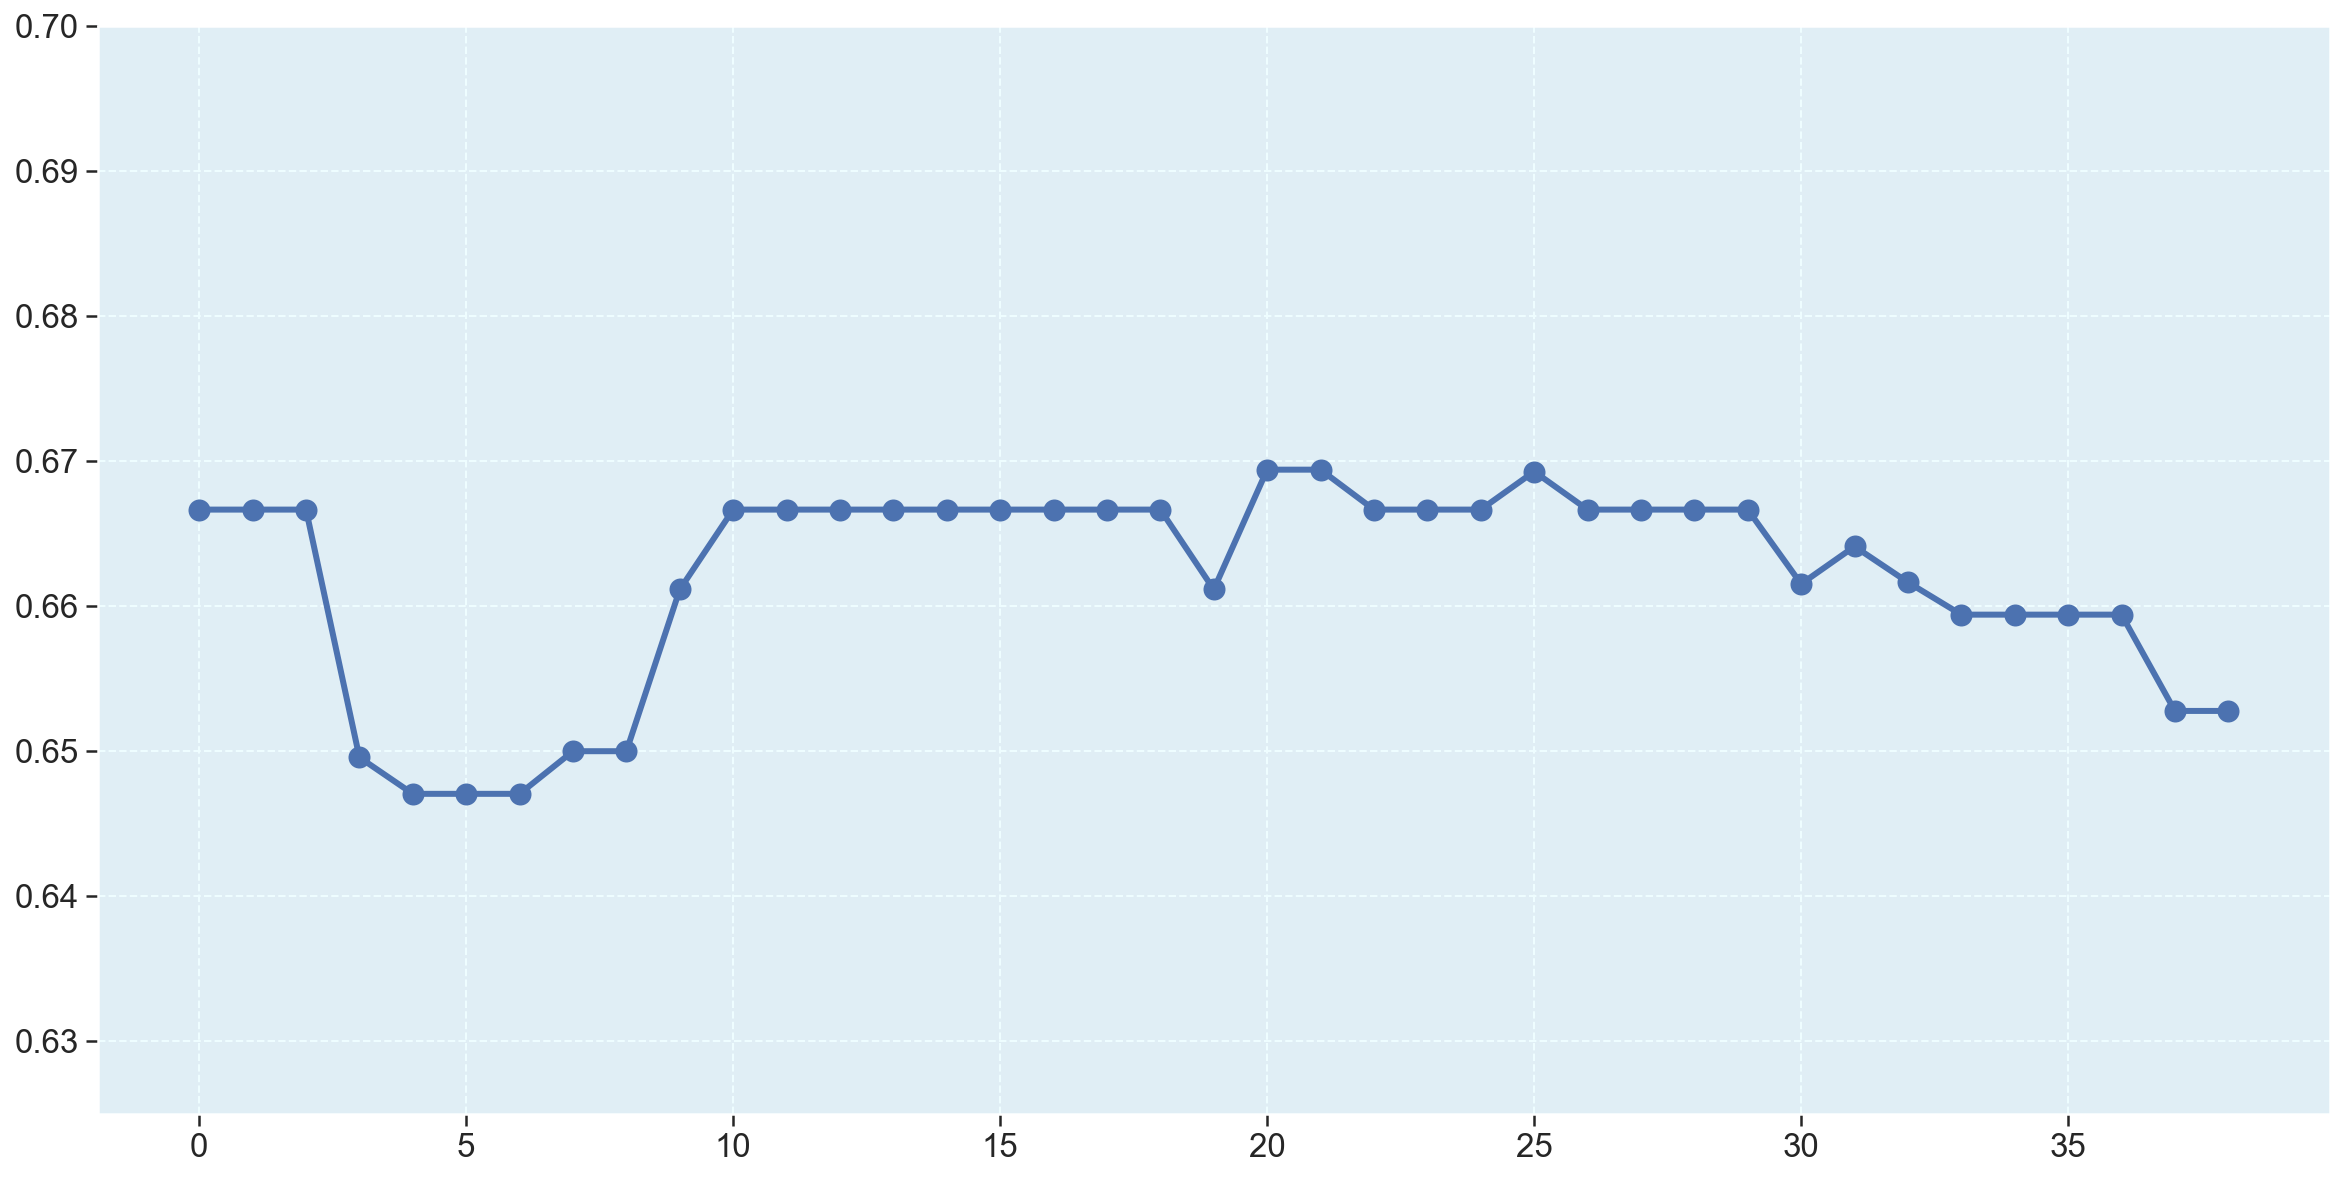

In [22]:
fig = plt.figure(figsize=(20, 10))

#plt.plot(frontend_metrics['em1'], linewidth=3, marker='o', markersize=10)
plt.plot(repos_metrics_list[0]['em1'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.625,.7, color="#c9f9ff", alpha=0.3)

plt.ylim(.625,.7)

### em2

(-0.001, 0.016)

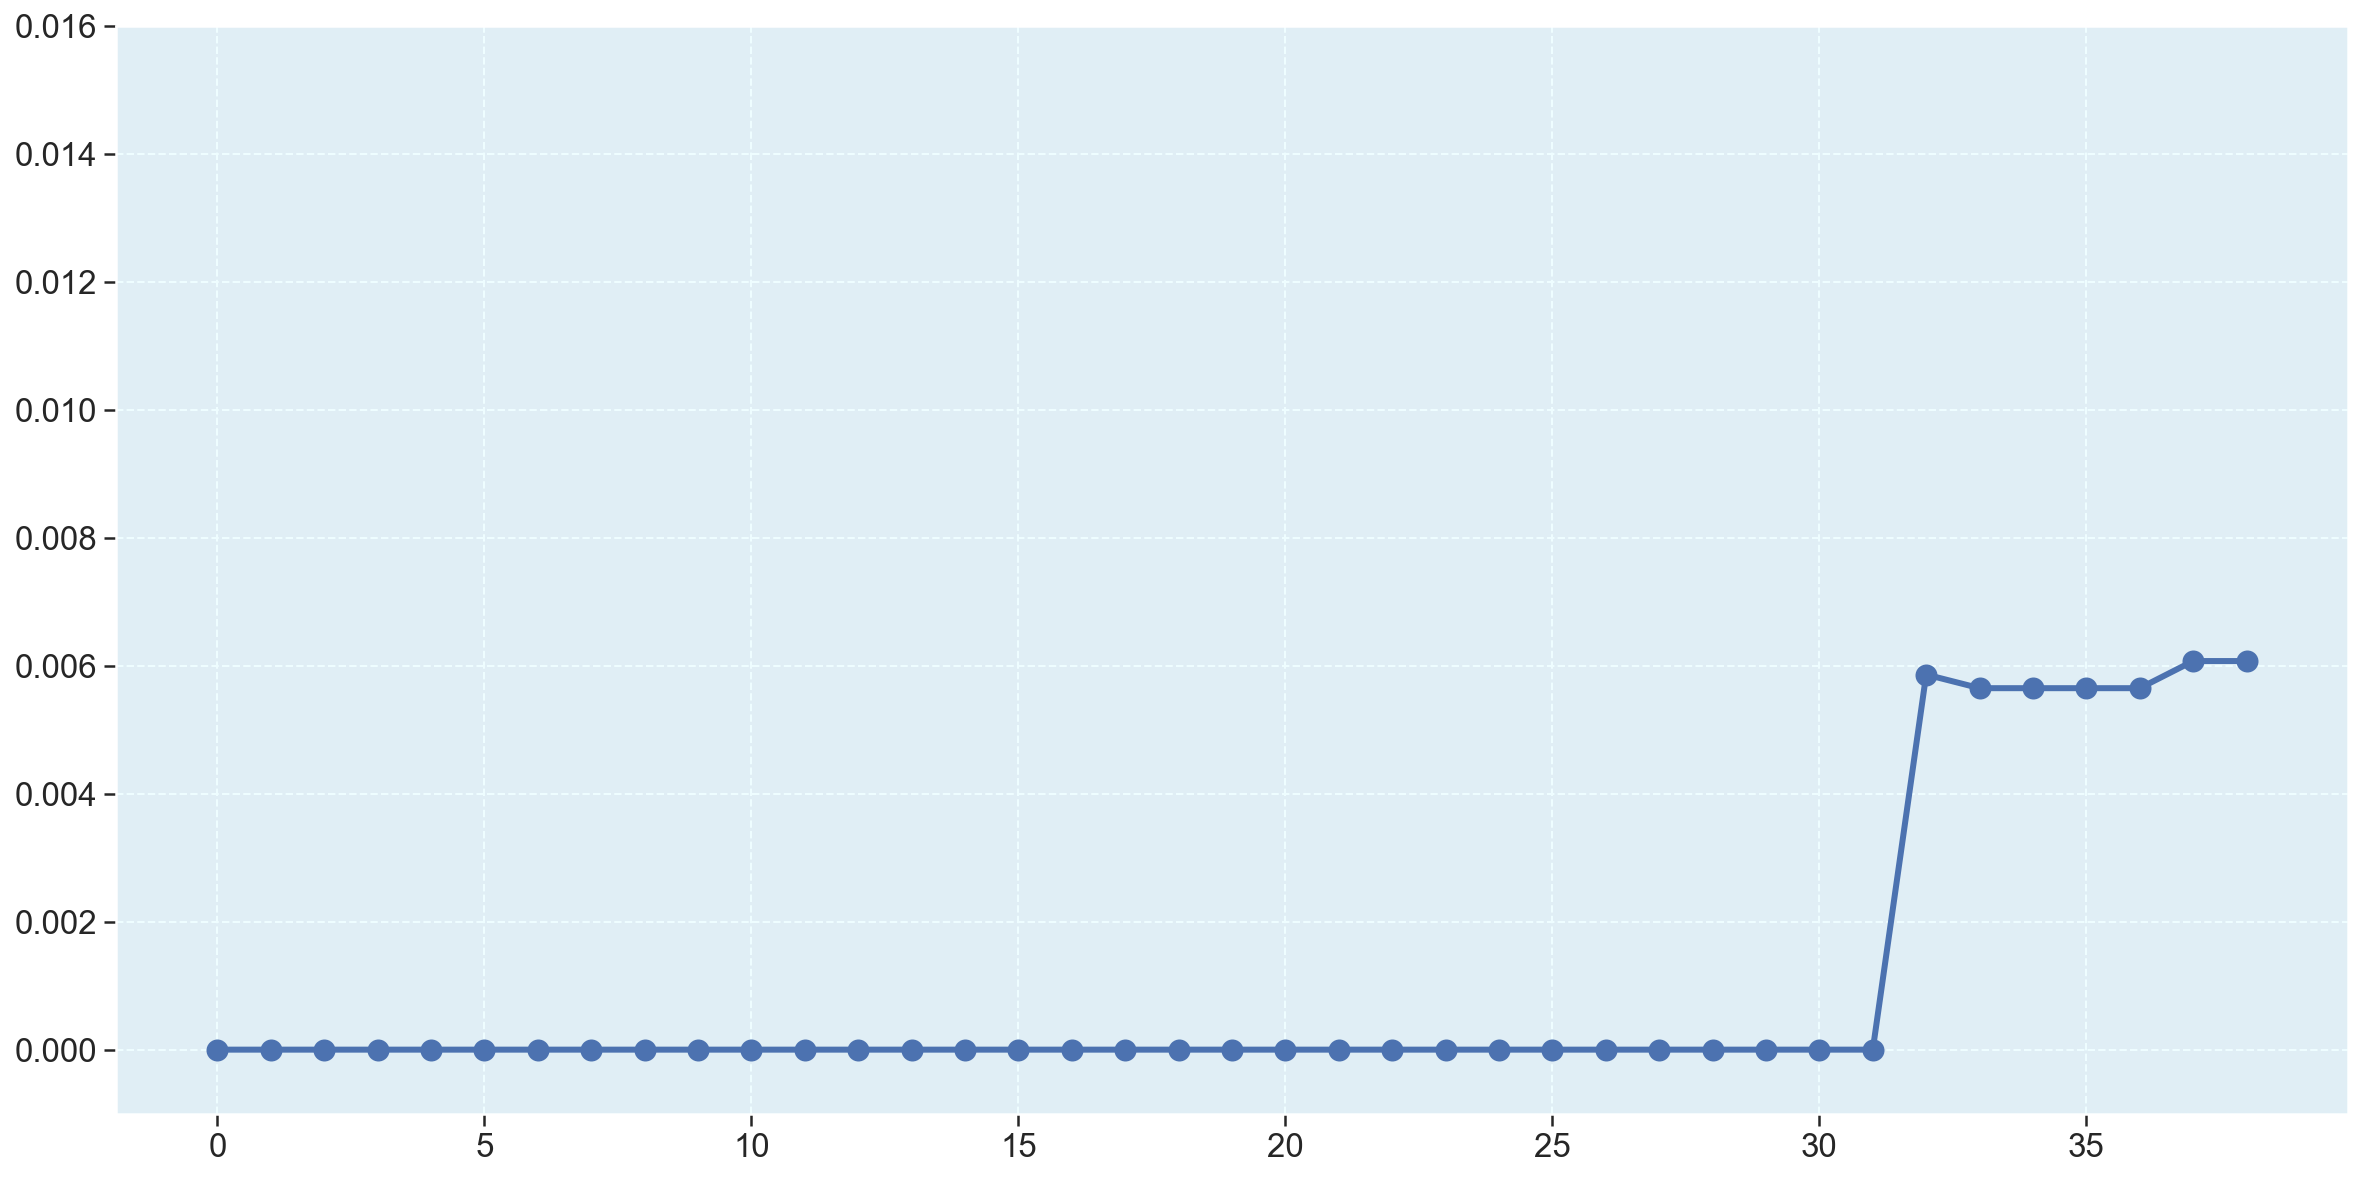

In [23]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repos_metrics_list[0]['em2'], linewidth=3, marker='o', markersize=10)


# Background color
plt.axhspan(-.001,.016, color="#c9f9ff", alpha=0.3)

plt.ylim(-.001,.016)

### em3

(0.95, 1.01)

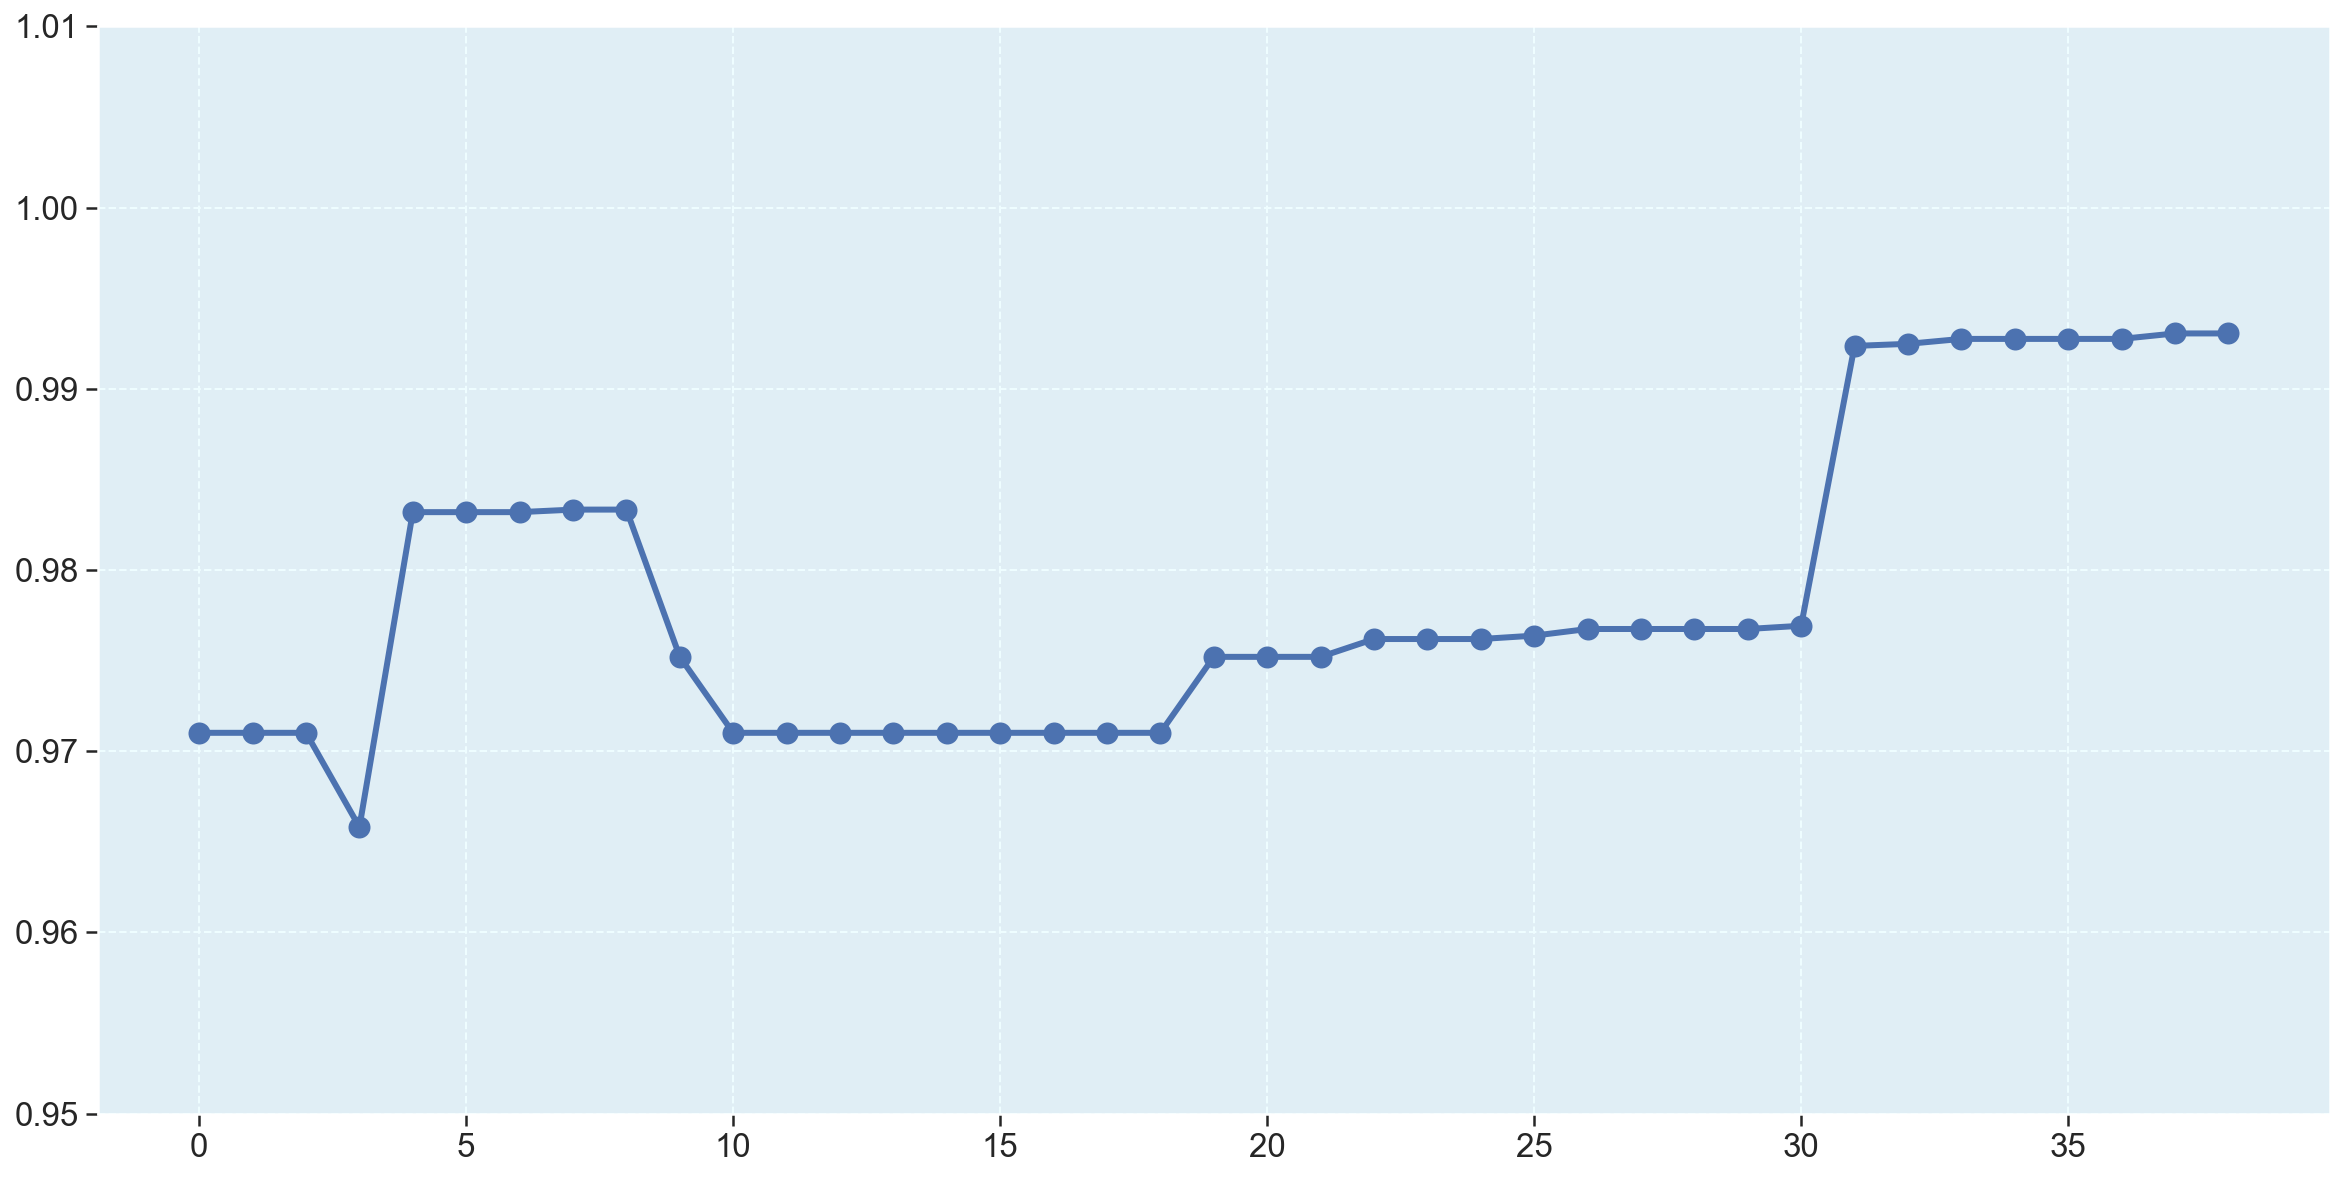

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repos_metrics_list[0]['em3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.95,1.01, color="#c9f9ff", alpha=0.3)

plt.ylim(.95,1.01)

### All metrics

(-0.02, 1.02)

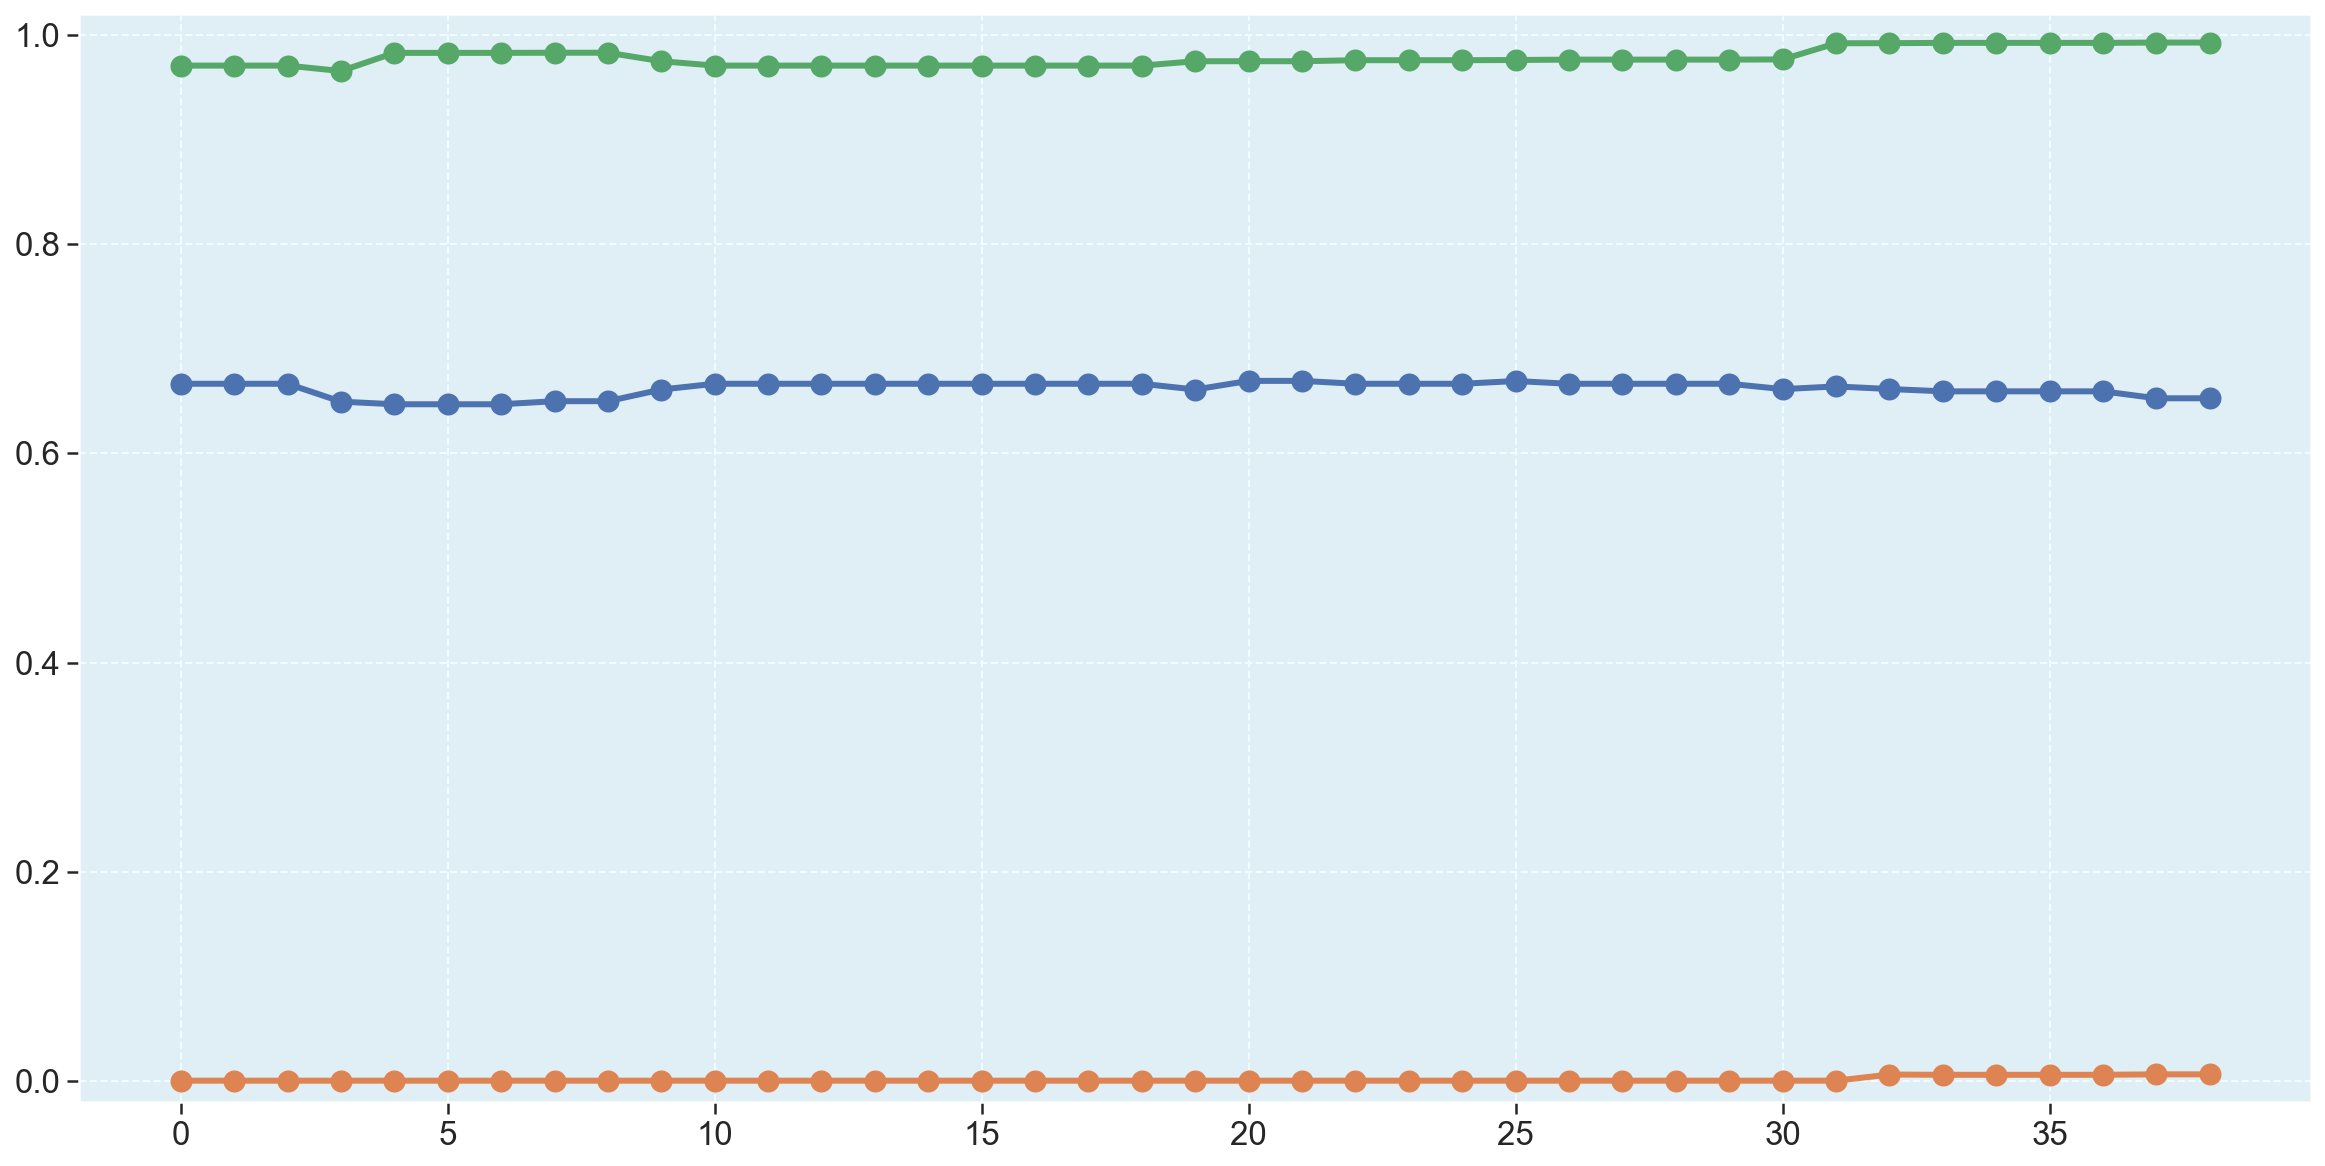

In [25]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repos_metrics_list[0]['em1'], linewidth=3, marker='o', markersize=10)
plt.plot(repos_metrics_list[0]['em2'], linewidth=3, marker='o', markersize=10)
plt.plot(repos_metrics_list[0]['em3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(-.02,1.02, color="#c9f9ff", alpha=0.3)

plt.ylim(-.02,1.02)

### Setting measures weighs

In [26]:
# wem1 = 33%
# wem2 = 33%
# wem3 = 33%

wem1=wem2=wem3 = 0.3374
SC_Modifiability_EM_Weights = np.array([wem1, wem2, wem3])

## Defining Modifiability quality sub-characteristic tensors per microservice.

In [27]:
def create_sc_tensor(measures_list, size_z):

    tensor_sc_measures = ts.tensor(measures_list).reshape((measures_list.shape[0],measures_list.shape[1],size_z))

    return tensor_sc_measures

repos_sc_measures_list = []

for repo_measures in repos_metrics_list:
    repos_sc_measures_list.append(np.array([repo_measures['em1'].astype(float),
                                            repo_measures['em2'].astype(float),
                                            repo_measures['em3'].astype(float)]))

t_sc_modifiability_microservices_list = []

t_sc_modifiability_microservices_list.append(create_sc_tensor(repos_sc_measures_list[0], 1))
t_sc_modifiability_microservices_list.append(create_sc_tensor(repos_sc_measures_list[1], 1))
t_sc_modifiability_microservices_list.append(create_sc_tensor(repos_sc_measures_list[2], 1))
t_sc_modifiability_microservices_list.append(create_sc_tensor(repos_sc_measures_list[3], 1))
t_sc_modifiability_microservices_list.append(create_sc_tensor(repos_sc_measures_list[4], 1))

print("Modifiability Tensor dimensions = " + str(t_sc_modifiability_microservices_list[0].ndim))

t_sc_modifiability_microservices_list[0]

Modifiability Tensor dimensions = 3


array([[[0.66666667],
        [0.66666667],
        [0.66666667],
        [0.64957265],
        [0.64705882],
        [0.64705882],
        [0.64705882],
        [0.65      ],
        [0.65      ],
        [0.66115702],
        [0.66666667],
        [0.66666667],
        [0.66666667],
        [0.66666667],
        [0.66666667],
        [0.66666667],
        [0.66666667],
        [0.66666667],
        [0.66666667],
        [0.66115702],
        [0.66942149],
        [0.66942149],
        [0.66666667],
        [0.66666667],
        [0.66666667],
        [0.66929134],
        [0.66666667],
        [0.66666667],
        [0.66666667],
        [0.66666667],
        [0.66153846],
        [0.66412214],
        [0.66165414],
        [0.65942029],
        [0.65942029],
        [0.65942029],
        [0.65942029],
        [0.65277778],
        [0.65277778]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

# Weighting tensor of the Modifiability Sub-Characteristic at measure level.

In [28]:
t_sc_modifiability_weighted_list = []

for i in range(len(t_sc_modifiability_microservices_list)):

    t_sc_modifiability_weighted = np.empty(t_sc_modifiability_microservices_list[i].shape)

    # t_sc_modifiability_frontend[:, :, 0][j] = Slice in a specific dimension and multiply by respective weight
    for j in range(t_sc_modifiability_microservices_list[i].ndim):
        t_sc_modifiability_weighted[:, :, 0][j] = np.tensordot(t_sc_modifiability_microservices_list[i][:,:,0][j],
                                                               SC_Modifiability_EM_Weights[j], 0)
    t_sc_modifiability_weighted_list.append(t_sc_modifiability_weighted)

t_sc_modifiability_weighted_list[0]


array([[[0.22493333],
        [0.22493333],
        [0.22493333],
        [0.21916581],
        [0.21831765],
        [0.21831765],
        [0.21831765],
        [0.21931   ],
        [0.21931   ],
        [0.22307438],
        [0.22493333],
        [0.22493333],
        [0.22493333],
        [0.22493333],
        [0.22493333],
        [0.22493333],
        [0.22493333],
        [0.22493333],
        [0.22493333],
        [0.22307438],
        [0.22586281],
        [0.22586281],
        [0.22493333],
        [0.22493333],
        [0.22493333],
        [0.2258189 ],
        [0.22493333],
        [0.22493333],
        [0.22493333],
        [0.22493333],
        [0.22320308],
        [0.22407481],
        [0.22324211],
        [0.22248841],
        [0.22248841],
        [0.22248841],
        [0.22248841],
        [0.22024722],
        [0.22024722]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

# Aggregating and weighting SC_Modifiability quality characteristic tensor

In [29]:
wsc1 = 1

t_sc_modifiability_agregated_list = []

for i in range(len(t_sc_modifiability_weighted_list)):

    #t_sc_modifiability_agregated = np.empty(t_sc_modifiability_weighted_list[i].shape)
    t_sc_modifiability_agregated = np.empty([t_sc_modifiability_weighted_list[i].shape[1]])

    for j in range(t_sc_modifiability_weighted_list[i].shape[1]):
        t_sc_modifiability_agregated[j] = np.linalg.norm(t_sc_modifiability_weighted_list[i][:,:,0][:,j])

    t_sc_modifiability_agregated_list.append(np.tensordot(t_sc_modifiability_agregated, wsc1, 0))

t_sc_modifiability_agregated_list[0]

array([0.39740415, 0.39740415, 0.39740415, 0.39271061, 0.3971234 ,
       0.3971234 , 0.3971234 , 0.39770923, 0.39770923, 0.39752487,
       0.39740415, 0.39740415, 0.39740415, 0.39740415, 0.39740415,
       0.39740415, 0.39740415, 0.39740415, 0.39740415, 0.39752487,
       0.39909629, 0.39909629, 0.39884509, 0.39884509, 0.39884509,
       0.39939736, 0.39899938, 0.39899938, 0.39899938, 0.39899938,
       0.3980765 , 0.40288574, 0.40246029, 0.40211892, 0.40211892,
       0.40211892, 0.40211892, 0.40096907, 0.40096907])

# Agregating and Weighting Maintainability quality characteristic tensor

In [30]:
wc1 = 1

t_c_maintainability_agregated_list = []

for i in range(len(t_sc_modifiability_agregated_list)):

    t_c_maintainability_agregated = np.empty([t_sc_modifiability_agregated_list[i].shape[0]])

    for j in range(t_sc_modifiability_agregated_list[i].shape[0]):
        t_c_maintainability_agregated[j] = np.linalg.norm(t_sc_modifiability_weighted_list[i][:,:,0][:,j])

    t_c_maintainability_agregated_list.append(np.tensordot(t_c_maintainability_agregated, wc1, 0))

t_c_maintainability_agregated_list[0]


array([0.39740415, 0.39740415, 0.39740415, 0.39271061, 0.3971234 ,
       0.3971234 , 0.3971234 , 0.39770923, 0.39770923, 0.39752487,
       0.39740415, 0.39740415, 0.39740415, 0.39740415, 0.39740415,
       0.39740415, 0.39740415, 0.39740415, 0.39740415, 0.39752487,
       0.39909629, 0.39909629, 0.39884509, 0.39884509, 0.39884509,
       0.39939736, 0.39899938, 0.39899938, 0.39899938, 0.39899938,
       0.3980765 , 0.40288574, 0.40246029, 0.40211892, 0.40211892,
       0.40211892, 0.40211892, 0.40096907, 0.40096907])

# Comparison of the product quality of two Releases. This comparison is obtained from cosine similarity between tensors.

In [31]:
SQC_1 = t_c_maintainability_agregated_list[0][0] # first_release from frontend repository
SQC_2 = t_c_maintainability_agregated_list[0][38] # last_release from frontend repository

distance.cosine(SQC_1, SQC_2)

0.0

# Intensity of difference between releases comparison

In [32]:
intensity_difference = SQC_2 - SQC_1

intensity_difference

0.0035649233634788002

In [33]:
frontend_metrics['Modifiability'] = t_c_maintainability_agregated_list[0].tolist()
frontend_metrics['Maintainability'] = t_c_maintainability_agregated_list[0].tolist()
frontend_metrics['SQC'] = t_c_maintainability_agregated_list[0].tolist()

users_metrics['Modifiability'] = t_c_maintainability_agregated_list[1].tolist()
users_metrics['Maintainability'] = t_c_maintainability_agregated_list[1].tolist()
users_metrics['SQC'] = t_c_maintainability_agregated_list[1].tolist()

sectors_metrics['Modifiability'] = t_c_maintainability_agregated_list[2].tolist()
sectors_metrics['Maintainability'] = t_c_maintainability_agregated_list[2].tolist()
sectors_metrics['SQC'] = t_c_maintainability_agregated_list[2].tolist()

demands_metrics['Modifiability'] = t_c_maintainability_agregated_list[3].tolist()
demands_metrics['Maintainability'] = t_c_maintainability_agregated_list[3].tolist()
demands_metrics['SQC'] = t_c_maintainability_agregated_list[3].tolist()

clients_metrics['Modifiability'] = t_c_maintainability_agregated_list[4].tolist()
clients_metrics['Maintainability'] = t_c_maintainability_agregated_list[4].tolist()
clients_metrics['SQC'] = t_c_maintainability_agregated_list[4].tolist()


column_names = ["em1", "em2", "em3", "Modifiability", "Maintainability", "SQC", "repository", "version" ]

frontend_metrics = frontend_metrics.reindex(columns=column_names)
users_metrics = users_metrics.reindex(columns=column_names)
sectors_metrics = sectors_metrics.reindex(columns=column_names)
demands_metrics = demands_metrics.reindex(columns=column_names)
clients_metrics = clients_metrics.reindex(columns=column_names)

frontend_metrics

,em1,em2,em3,Modifiability,Maintainability,SQC,repository,version
0,0.666667,0.000000,0.971014,0.397404,0.397404,0.397404,Frontend,v0.1
1,0.666667,0.000000,0.971014,0.397404,0.397404,0.397404,Frontend,v0.10.0
2,0.666667,0.000000,0.971014,0.397404,0.397404,0.397404,Frontend,v0.10.1
3,0.649573,0.000000,0.965812,0.392711,0.392711,0.392711,Frontend,v0.10.2
4,0.647059,0.000000,0.983193,0.397123,0.397123,0.397123,Frontend,v0.11.0
5,0.647059,0.000000,0.983193,0.397123,0.397123,0.397123,Frontend,v0.11.1
6,0.647059,0.000000,0.983193,0.397123,0.397123,0.397123,Frontend,v0.12.0
7,0.650000,0.000000,0.983333,0.397709,0.397709,0.397709,Frontend,v0.13.0
8,0.650000,0.000000,0.983333,0.397709,0.397709,0.397709,Frontend,v0.14.0
9,0.661157,0.000000,0.975207,0.397525,0.397525,0.397525,Frontend,v0.14.1


# Plotting the total quality(SQC) from SiGed frontend microservice

(0.32, 0.44)

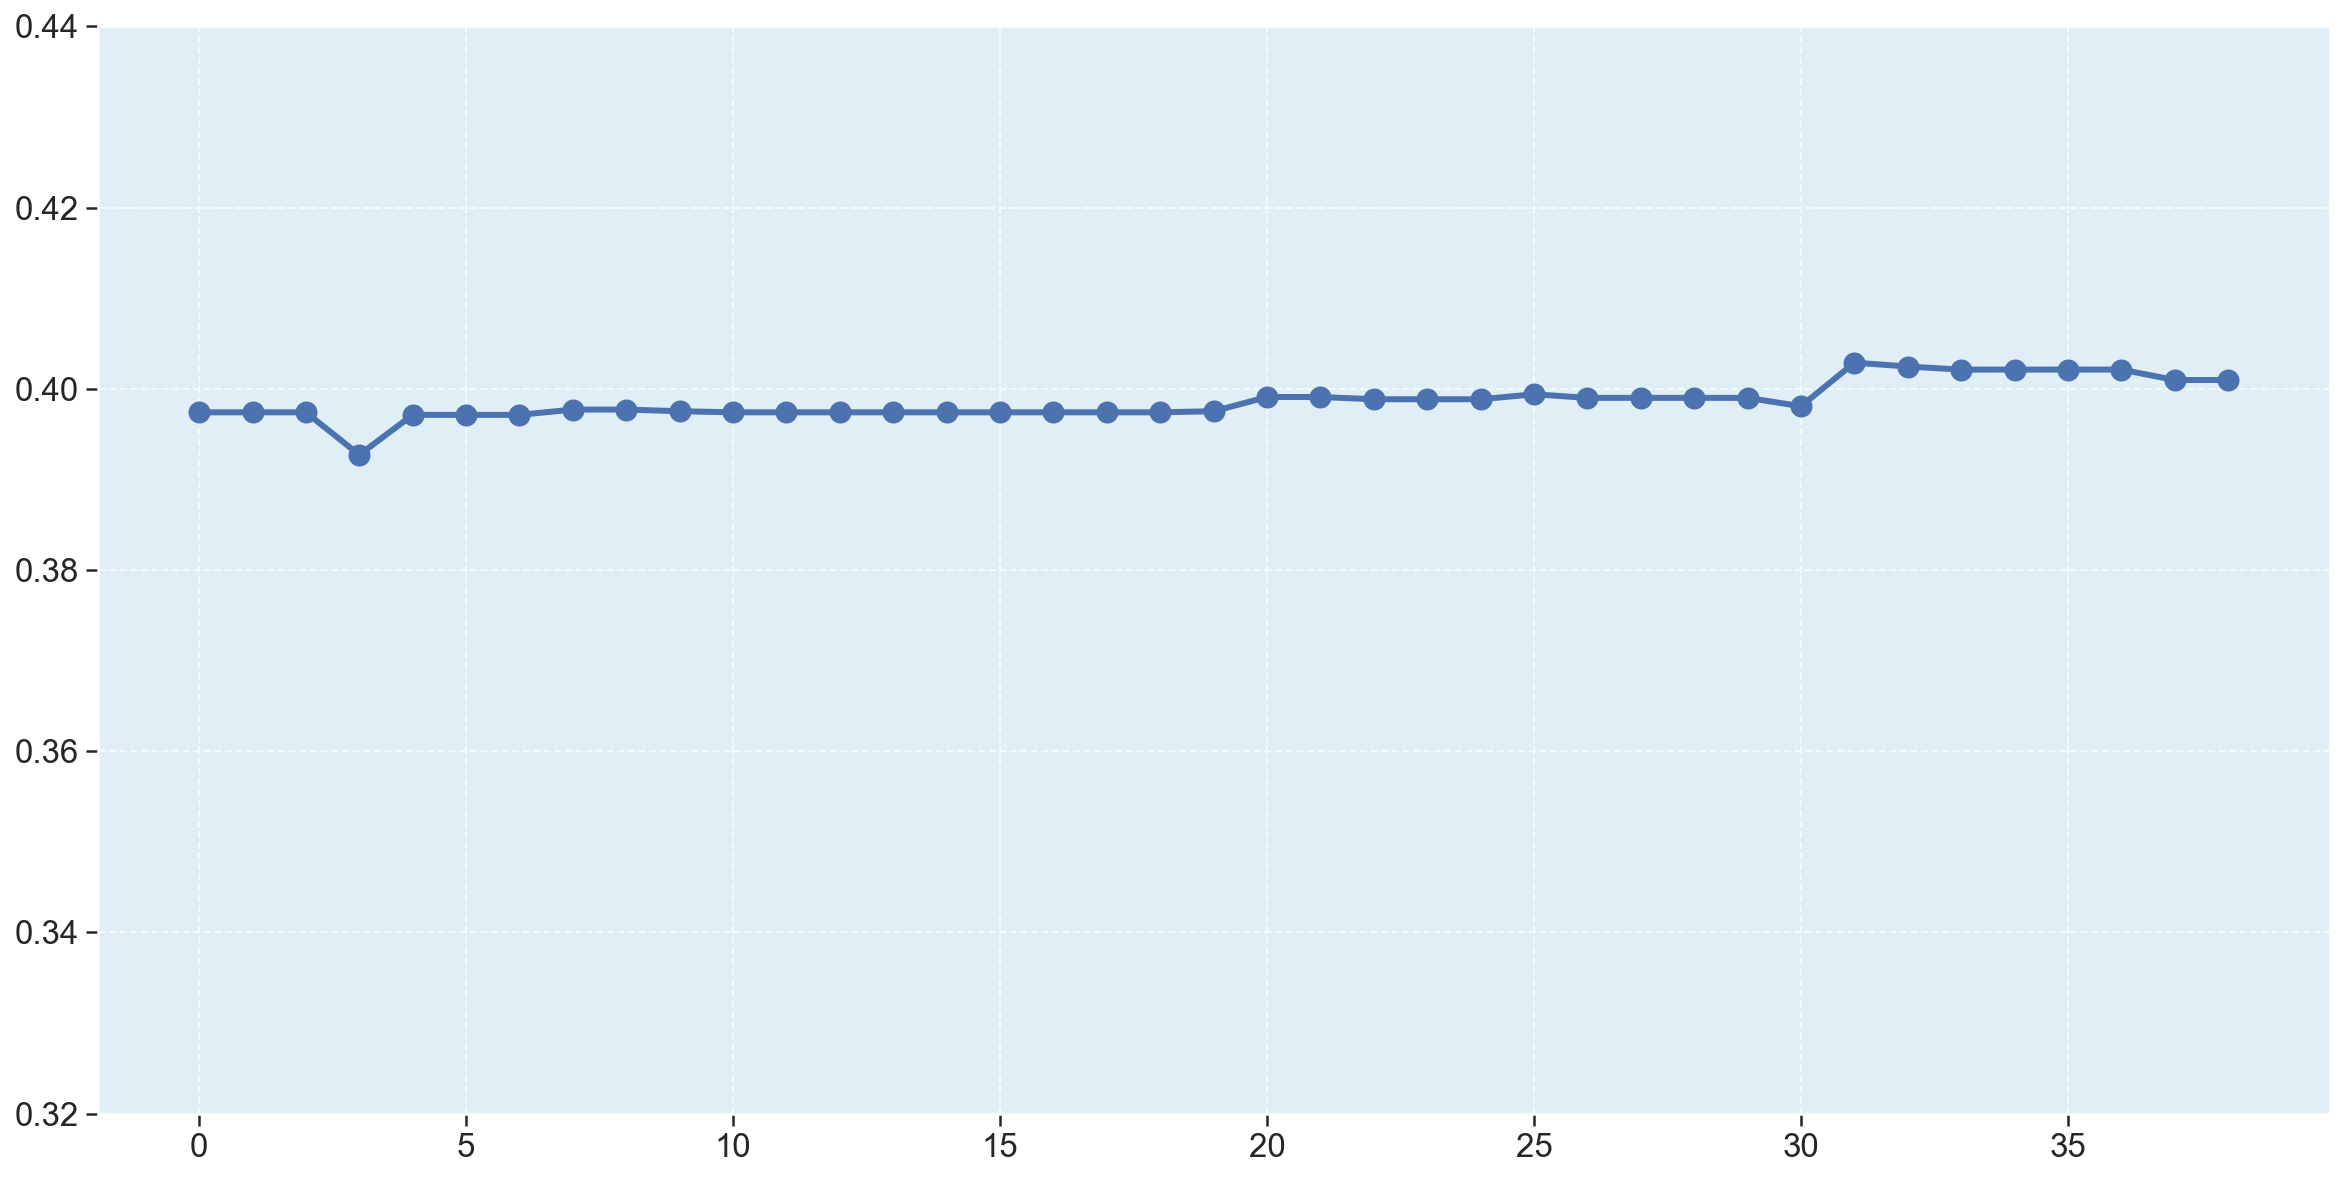

In [34]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['SQC'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.32,.44, color="#c9f9ff", alpha=0.3)

plt.ylim(.32,.44)

# Plotting the total quality(SQC) from all SiGed microservices

(0.34, 0.44)

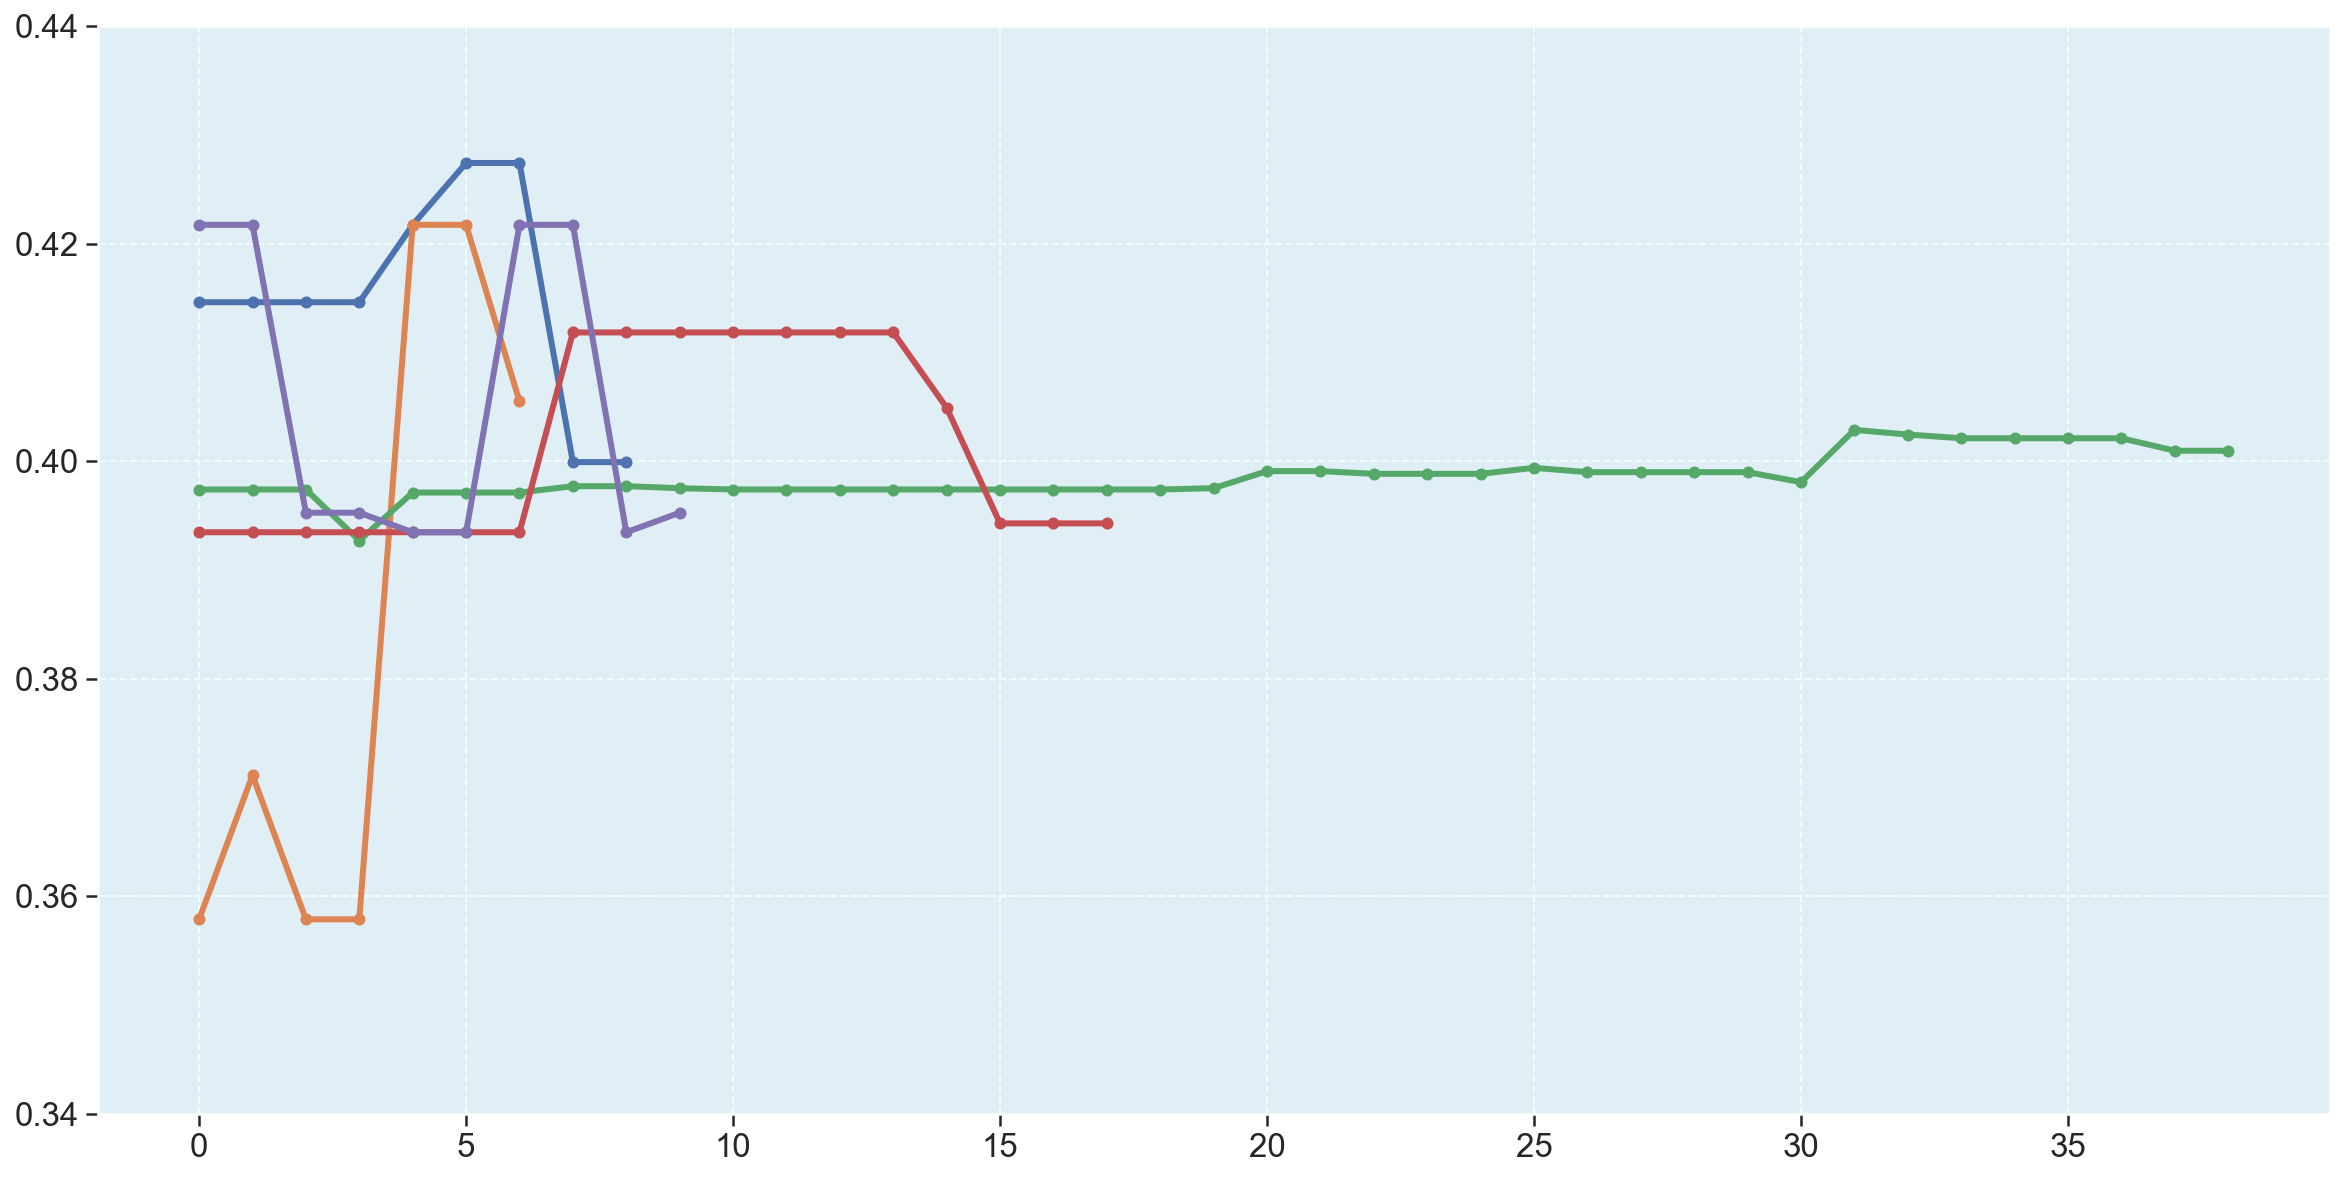

In [35]:
fig = plt.figure(figsize=(20, 10))

plt.plot(users_metrics['SQC'], linewidth=3, marker='o', markersize=5)
plt.plot(sectors_metrics['SQC'], linewidth=3, marker='o', markersize=5)
plt.plot(frontend_metrics['SQC'], linewidth=3, marker='o', markersize=5)
plt.plot(demands_metrics['SQC'], linewidth=3, marker='o', markersize=5)
plt.plot(clients_metrics['SQC'], linewidth=3, marker='o', markersize=5)

# Background color
plt.axhspan(.34,.44, color="#c9f9ff", alpha=0.3)

plt.ylim(.34,.44)

# Plotting the dataset with MeasureSoftGram's calculations

In [36]:
metrics_df = pd.concat([users_metrics, sectors_metrics, frontend_metrics, demands_metrics,
                        clients_metrics], ignore_index=True)

metrics_df

,em1,em2,em3,Modifiability,Maintainability,SQC,repository,version
0,0.714286,0.000000,1.000000,0.414632,0.414632,0.414632,Users,v0.1
1,0.714286,0.000000,1.000000,0.414632,0.414632,0.414632,Users,v0.2
2,0.714286,0.000000,1.000000,0.414632,0.414632,0.414632,Users,v0.3
3,0.714286,0.000000,1.000000,0.414632,0.414632,0.414632,Users,v0.3.0
4,0.750000,0.000000,1.000000,0.421750,0.421750,0.421750,Users,v0.3.1
5,0.777778,0.000000,1.000000,0.427439,0.427439,0.427439,Users,v0.3.2
6,0.777778,0.000000,1.000000,0.427439,0.427439,0.427439,Users,v1.0.0
7,0.636364,0.000000,1.000000,0.399923,0.399923,0.399923,Users,v1.0.1
8,0.636364,0.000000,1.000000,0.399923,0.399923,0.399923,Users,v1.0.2
9,0.750000,0.000000,0.750000,0.357867,0.357867,0.357867,Sectors,v0.1.0


# Generating dataset in .CSV format

In [42]:
metrics_df.to_excel('data/measuresoftgram-siged-dataset-23-03-2021-08-05-2021-excel.xlsx', header=False, index = False)
metrics_df.to_csv('data/measuresoftgram-siged-dataset-23-03-2021-08-05-2021-csv.csv', header=False, index = False)
#metrics_df.to_json('data/metrics_df_json.json', index = False)


# Reading MeasureSoftGram and Q-Rapids dataset .CSV

In [45]:
qrapids_df = pd.read_csv('data/qrapids-siged-dataset-23-03-2021-08-05-2021-csv.csv', sep=',', header=None,
                              names=['m1', 'm2', 'm3', 'repository', 'version', 'asc1', 'ac1','total'], dtype='a')

qrapids_df

measuresoftgram_df = pd.read_csv('data/measuresoftgram-siged-dataset-23-03-2021-08-05-2021-csv.csv', sep=',',
                                 header=None, names=column_names, dtype='a')

measuresoftgram_df

,em1,em2,em3,Modifiability,Maintainability,SQC,repository,version
0,0.7142857142857143,0.0,1.0,0.41463207787145456,0.41463207787145456,0.41463207787145456,Users,v0.1
1,0.7142857142857143,0.0,1.0,0.41463207787145456,0.41463207787145456,0.41463207787145456,Users,v0.2
2,0.7142857142857143,0.0,1.0,0.41463207787145456,0.41463207787145456,0.41463207787145456,Users,v0.3
3,0.7142857142857143,0.0,1.0,0.41463207787145456,0.41463207787145456,0.41463207787145456,Users,v0.3.0
4,0.75,0.0,1.0,0.42174999999999996,0.42174999999999996,0.42174999999999996,Users,v0.3.1
5,0.7777777777777778,0.0,1.0,0.4274390982538324,0.4274390982538324,0.4274390982538324,Users,v0.3.2
6,0.7777777777777778,0.0,1.0,0.4274390982538324,0.4274390982538324,0.4274390982538324,Users,v1.0.0
7,0.6363636363636364,0.0,1.0,0.399923434820977,0.399923434820977,0.399923434820977,Users,v1.0.1
8,0.6363636363636364,0.0,1.0,0.399923434820977,0.399923434820977,0.399923434820977,Users,v1.0.2
9,0.75,0.0,0.75,0.3578667419585117,0.3578667419585117,0.3578667419585117,Sectors,v0.1.0


# Statics Treatments

In [46]:
def is_normal(dist):

    k2, normal_Test_Pval = stats.normaltest(dist, axis=None)

    if (normal_Test_Pval < 0.05): # alpha value is 0.05 or 5%
        return False

    return True

dist_true = qrapids_df.iloc[:,[7]].to_numpy('float')
dist_predict = measuresoftgram_df.iloc[:,[5]].to_numpy('float')

def test_homoscedastic(dist_x, dist_y):
    # perform Bartlett's test - Homoscedastic
    b_stats, b_p_val = stats.bartlett(dist_x, dist_y)

    return b_stats, b_p_val

#define F-test function : copied from https://www.statology.org/f-test-python/
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic
    dfn = x.size-1 #define degrees of freedom numerator
    dfd = y.size-1 #define degrees of freedom denominator
    p = 1 - stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic
    return f, p

In [47]:
# alpha value is 0.05 or 5%
alpha = np.float64(0.05)

dist_control = qrapids_df.iloc[:,[7]].to_numpy('float')
dist_predict = measuresoftgram_df.iloc[:,[5]].to_numpy('float')

dist_list = []
dist_list.append(dist_control)
dist_list.append(dist_predict)

measuresoftgram_df['model'] = 'MeasureSoftGram'
measuresoftgram_df['total'] = measuresoftgram_df.iloc[:,5].astype(float)
qrapids_df['model'] = 'Q-Rapids'
qrapids_df['SQC'] = qrapids_df.iloc[:,7].astype(float)



# Descriptive Statistics

In [48]:
print('Descriptive Statitics from Q-Rapids: '+ str(stats.describe(dist_control)))
print('Min: ' + str(dist_control.min(axis=0)))
print('Max: ' + str(dist_control.max(axis=0)))
print('Mean: '+ str(dist_control.mean(axis=0)))
print('Median: '+ str(np.median(dist_control, axis=0)))
print('Std: ' + str(dist_control.std(axis=0)))
print('Variance: ' + str(dist_control.var(axis=0)) + '\n')

print('Descriptive Statitics from MeasuresotGram: '+ str(stats.describe(dist_predict)))
print('Min: ' + str(dist_predict.min(axis=0)))
print('Max: ' + str(dist_predict.max(axis=0)))
print('Mean: '+ str(dist_predict.mean(axis=0)))
print('Median: '+ str(np.median(dist_predict, axis=0)))
print('Std: ' + str(dist_predict.std(axis=0)))
print('Variance: ' + str(dist_predict.var(axis=0)))

Descriptive Statitics from Q-Rapids: DescribeResult(nobs=83, minmax=(array([0.495]), array([0.58666667])), mean=array([0.5452372]), variance=array([0.0003307]), skewness=array([-0.05288009]), kurtosis=array([1.03955366]))
Min: [0.495]
Max: [0.58666667]
Mean: [0.5452372]
Median: [0.54214286]
Std: [0.01807517]
Variance: [0.00032671]

Descriptive Statitics from MeasuresotGram: DescribeResult(nobs=83, minmax=(array([0.35786674]), array([0.4274391])), mean=array([0.40065491]), variance=array([0.00016653]), skewness=array([-0.80978293]), kurtosis=array([3.02485758]))
Min: [0.35786674]
Max: [0.4274391]
Mean: [0.40065491]
Median: [0.39884509]
Std: [0.01282673]
Variance: [0.00016452]


#  Normality Test

In [49]:
print('*** Testing Normality - Santo Agostinho ****')
if is_normal(dist_predict):
    print("MeasuresftGram has not a normal distribution")
else:
    print("MeasuresftGram has a normal distribution")

if is_normal(dist_predict):
    print("Q-Rapids has not a normal distribution")
else:
    print("Q-Rapids has a normal distribution")

*** Testing Normality - Santo Agostinho ****
MeasuresftGram has a normal distribution
Q-Rapids has a normal distribution


#  Homoscedastic Test

In [55]:
print('** Testing Homoscedastic - Bartletts test **')
b_stats, b_p_val = test_homoscedastic(dist_control[:, 0], dist_predict[:, 0])

if b_p_val > alpha:
    print('The variance among each Qrapids and MeasureSoftGram distributions is equal')
else:
    print('At least one group in MeasureSoftGram has a variance that is not equal to the Q-Rapids.')

** Testing Homoscedastic - Bartletts test **
At least one group in MeasureSoftGram has a variance that is not equal to the Q-Rapids.


# Histogram

<Figure size 2160x1440 with 0 Axes>

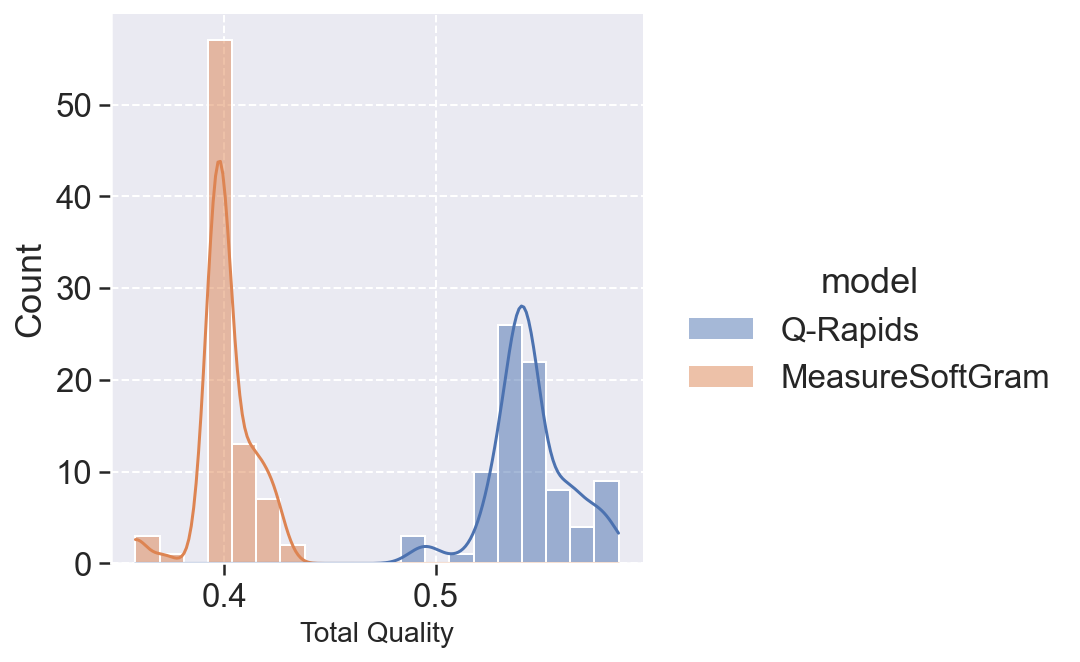

In [65]:
b = pd.DataFrame({ 'model': measuresoftgram_df.iloc[:,8], 'SQC' : measuresoftgram_df.iloc[:,5].astype(float)})
a = pd.DataFrame({ 'model': qrapids_df.iloc[:,8], 'SQC' : qrapids_df.iloc[:,9].astype(float)})

df = a.append(b)

fig = plt.figure(figsize=(30, 20))

sns.displot(df, x="SQC", hue="model", bins=20, kde=True)

plt.xlabel('Total Quality', fontsize=14)

plt.show()

# Boxplot

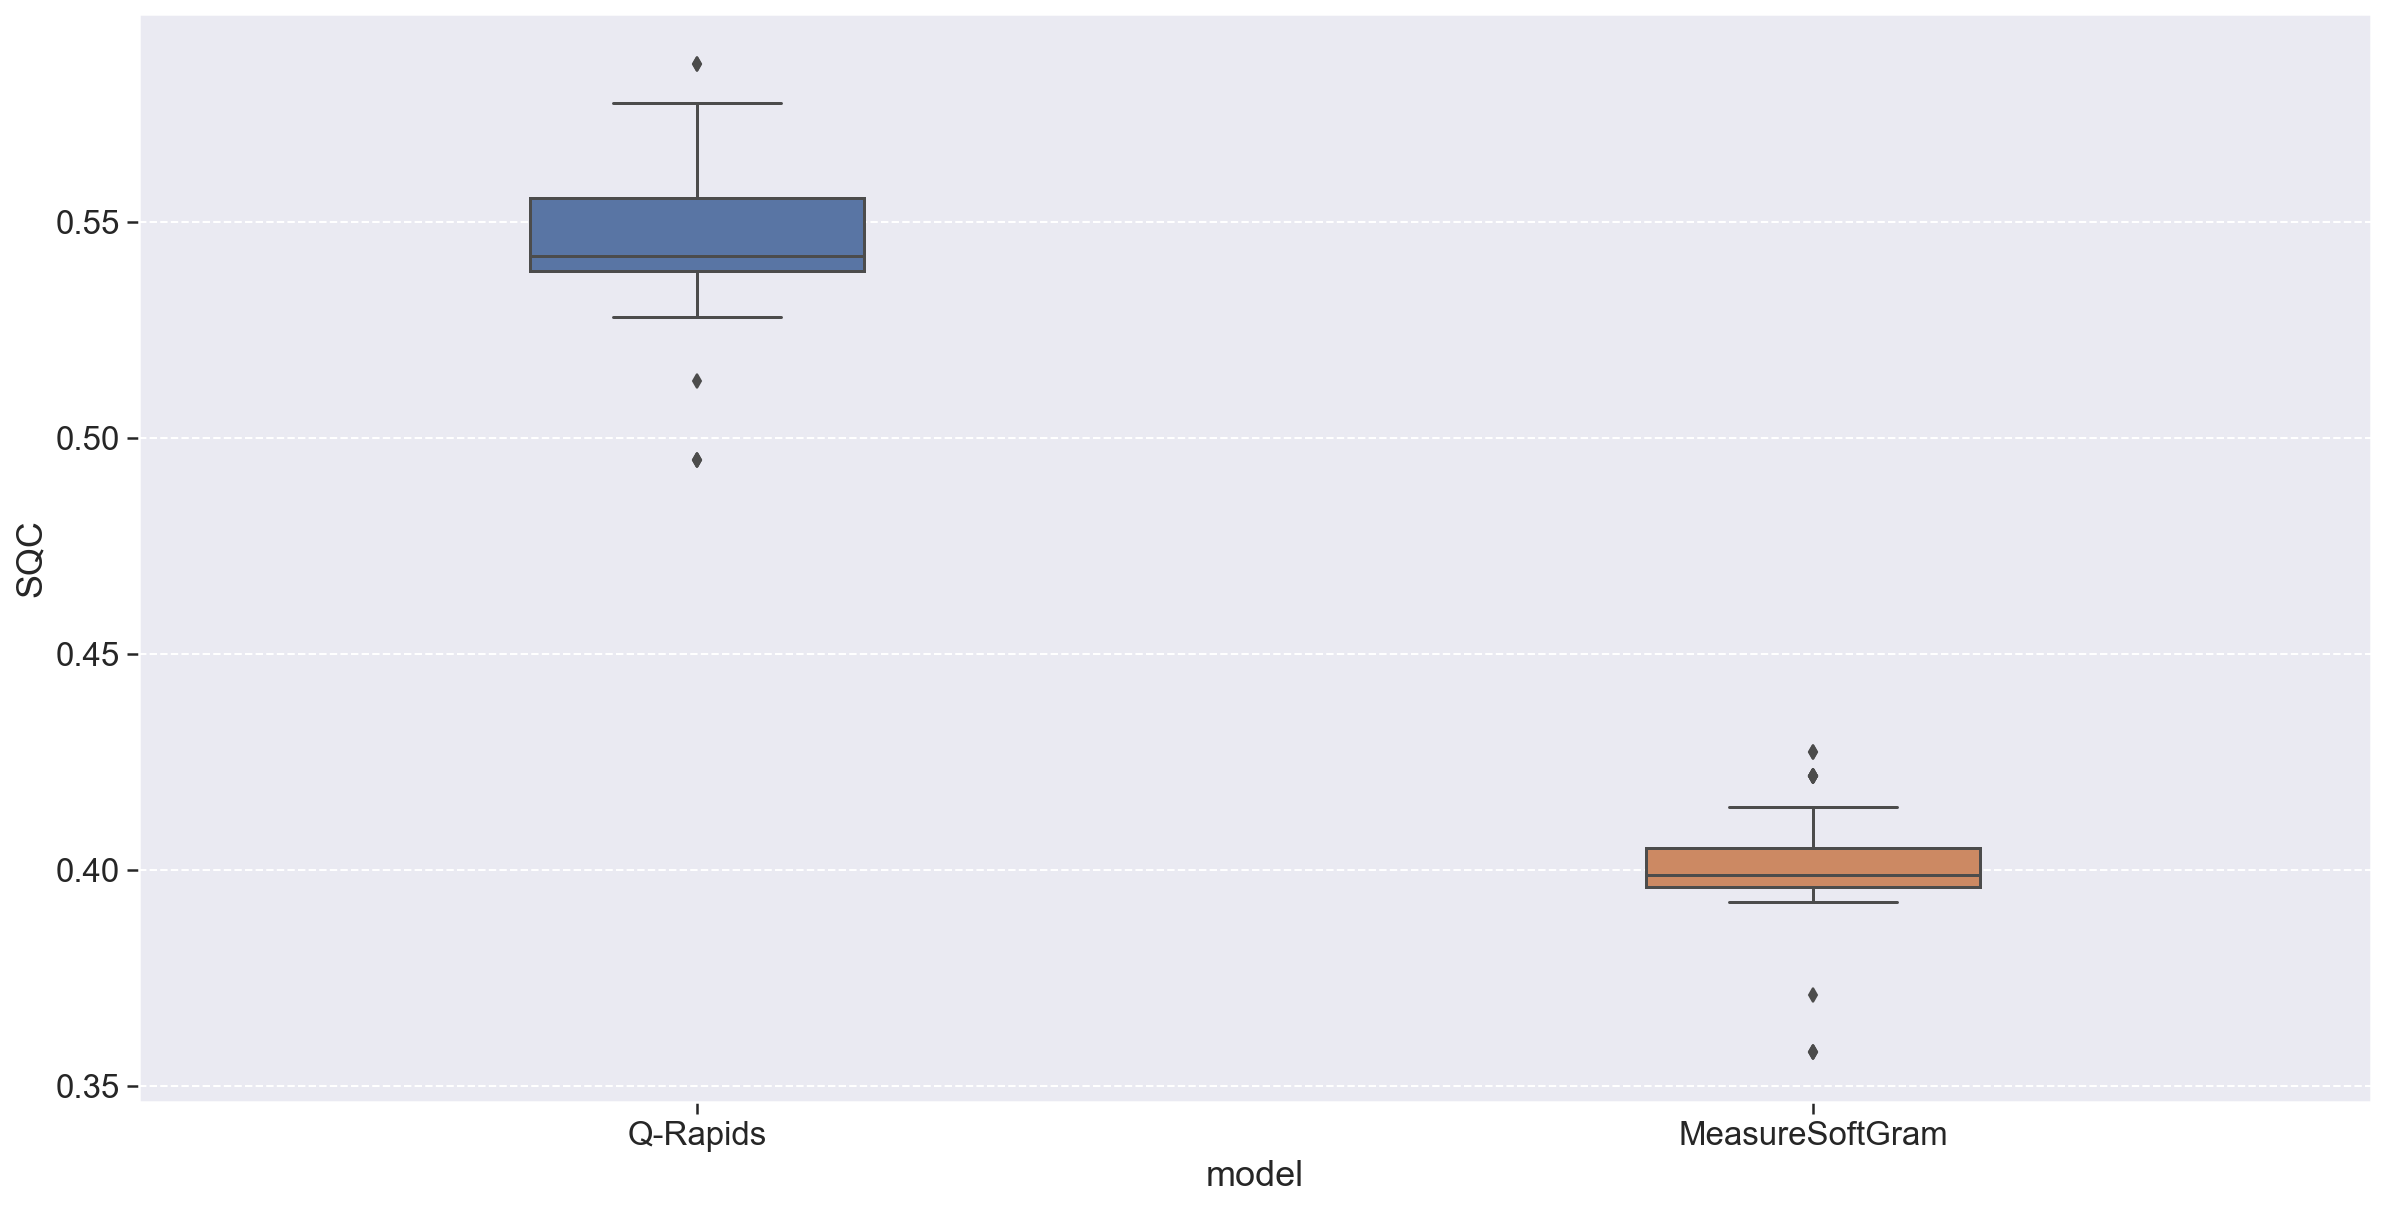

In [63]:
fig = plt.figure(figsize=(20, 10))
sns.boxplot(data=df, x='model', y='SQC', width=0.3)

plt.show()

# Scatter

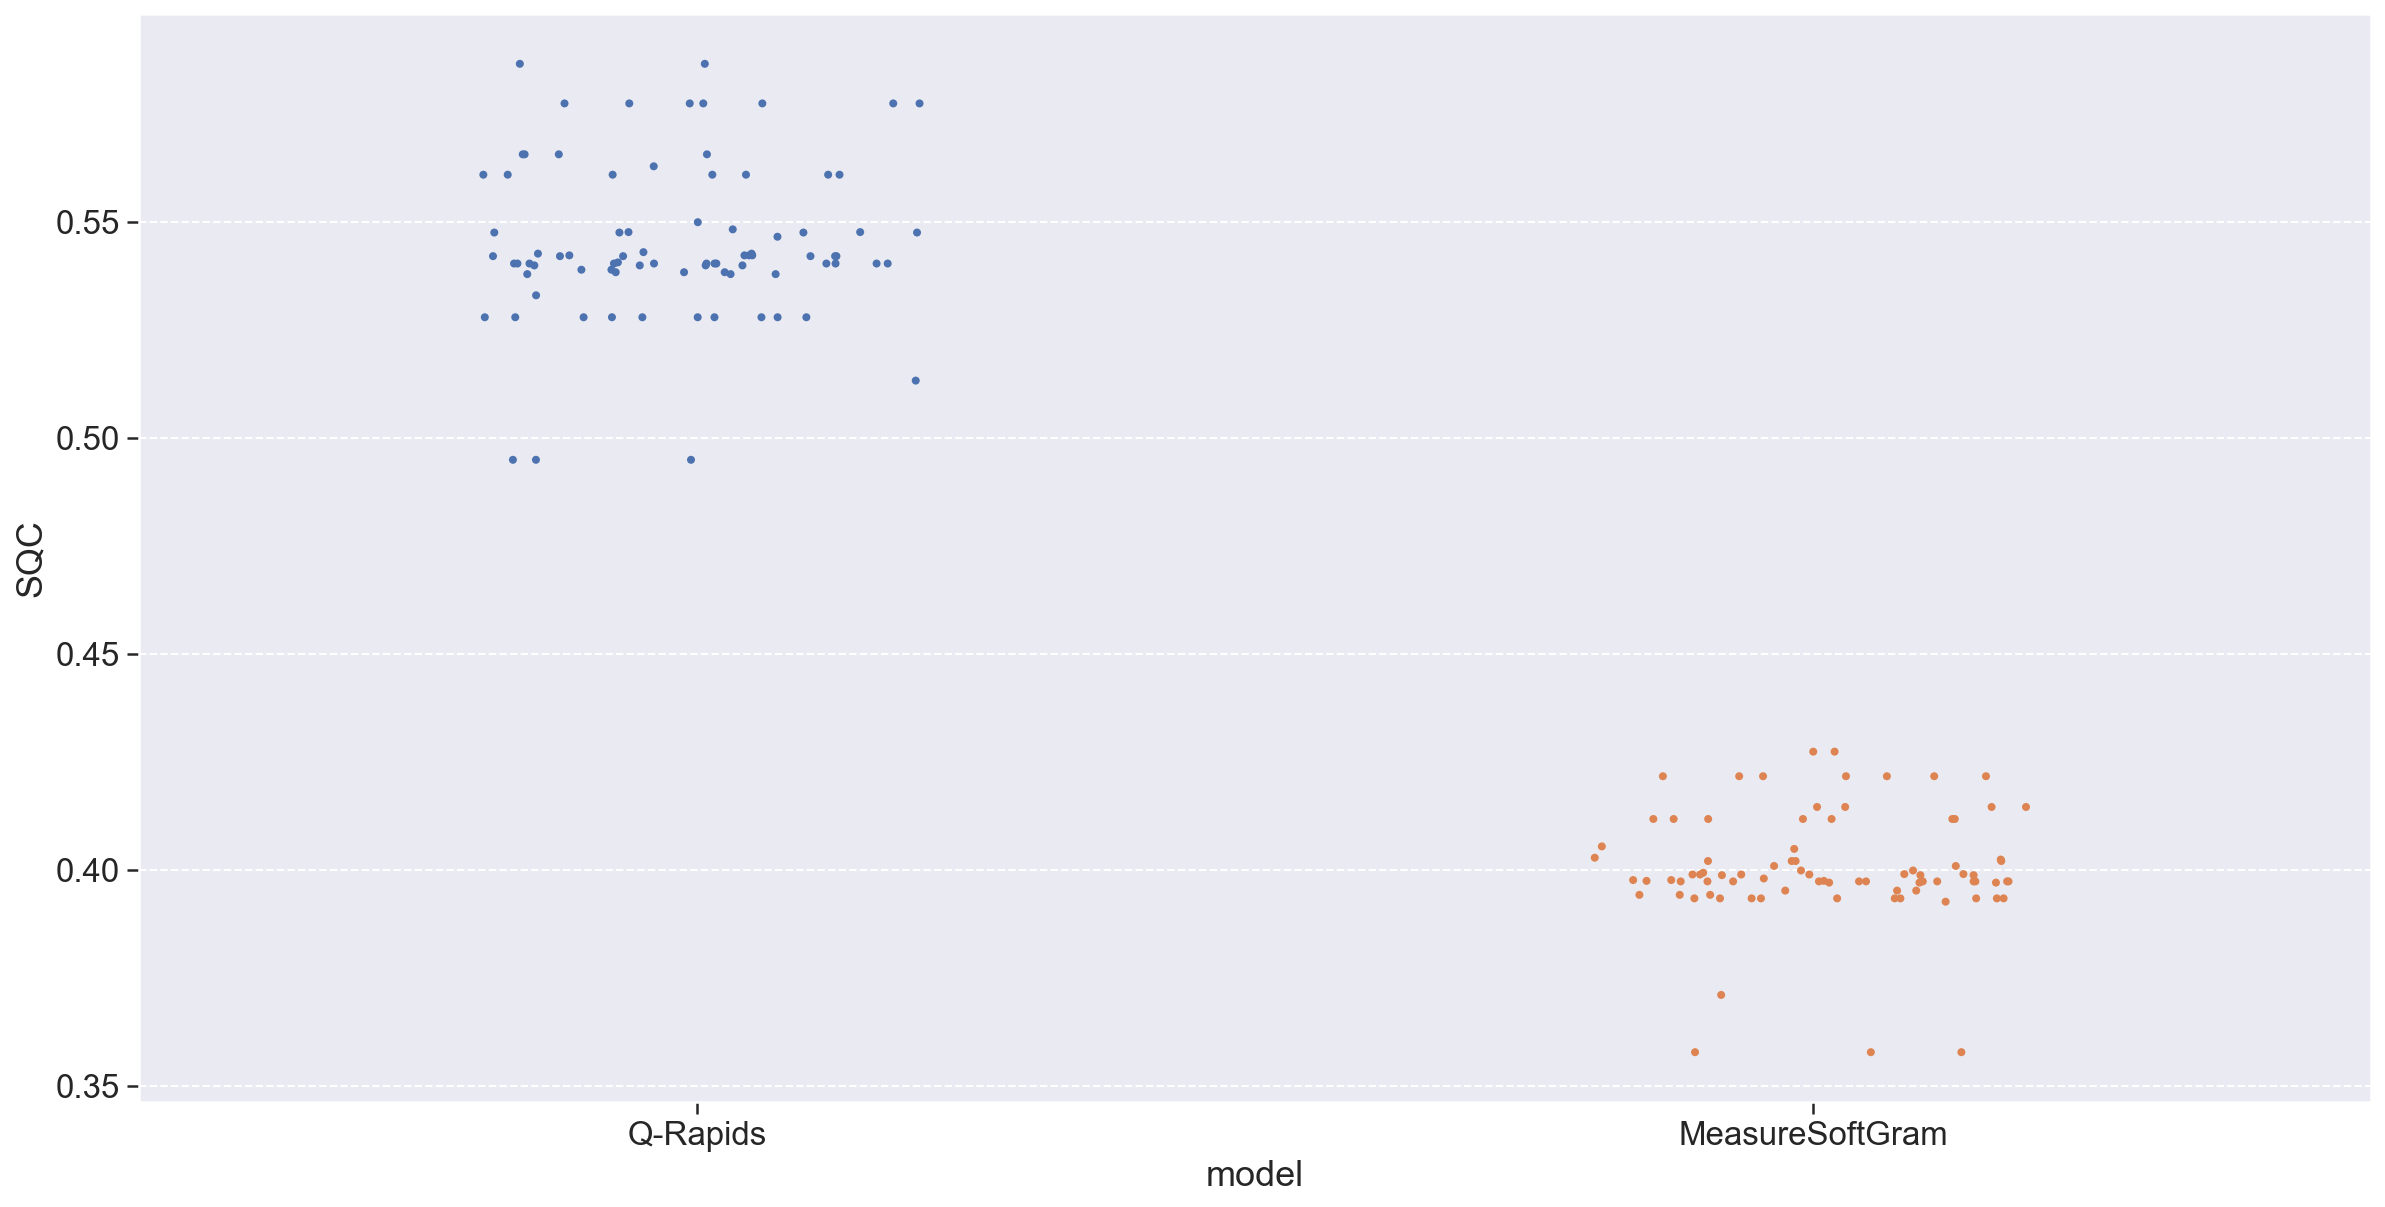

In [66]:
fig = plt.figure(figsize=(20, 10))
sns.stripplot(data=df, x="model", y="SQC", jitter=0.2, size=4)

plt.show()

# Hypothesis Test - Paired T-test

#### H<sub>0</sub> means that mean difference between pairs of measures of all the sample is equal.

#### H<sub>null</sub> means at least two samples have a different variant ratio distribution.

## <center>H<sub>null</sub>    : $\mu  $<sub>MeasureSoftGram_SQC</sub>  =  $\mu  $<sub>Q-Rapids_UQ</sub></center>
## <center>H<sub>0</sub>  : $\mu  $<sub>MeasureSoftGram_SQC</sub>  <>  $\mu  $<sub>Q-Rapids_UQ</sub></center>

In [60]:
tt_stat, tt_pval = stats.ttest_rel(dist_control, dist_predict)

# interpret
alpha = 0.05

if tt_pval > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

print('Paired T-test Statistics=%.10f, p=%.10f' % (tt_stat, tt_pval))

Different distribution (reject H0)
Paired T-test Statistics=211.2132750965, p=0.0000000000


# Hypothesis Test - F-test

#### H<sub>null</sub> means that the estimated ratio variance populations are equal.

#### H<sub>0</sub> means that at least two samples have a different distribution.

## <center>H<sub>0</sub>    : $\mu  $<sub>MeasureSoftGram_SQC</sub>  =  $\mu  $<sub>Q-Rapids_UQ</sub></center>
## <center>H<sub>1</sub>  : $\mu  $<sub>MeasureSoftGram_SQC</sub>  <>  $\mu  $<sub>Q-Rapids_UQ</sub></center>
## <center>H<sub>2</sub>  : $\mu  $<sub>MeasureSoftGram_SQC</sub>  >  $\mu  $<sub>Q-Rapids_UQ</sub></center>
## <center>H<sub>3</sub>  : $\mu  $<sub>MeasureSoftGram_SQC</sub>  <  $\mu  $<sub>Q-Rapids_UQ</sub></center>

In [61]:
f_stats, f_p_val = f_test(dist_control, dist_predict)

if f_p_val > alpha:
    print('Reject the null hypothesis that Var(Qrapids) = Var(MeasureSoftGram)')
elif f_p_val <= alpha:
    print('Fail Reject the null hypothesis Var(Qrapids) < Var(MeasureSoftGram)')

print('F-test statistics: '  + str(f_stats) + 'F-test p-value: '  + str(f_p_val))




Fail Reject the null hypothesis Var(Qrapids) < Var(MeasureSoftGram)
F-test statistics: 1.9857890163574945F-test p-value: 0.00108064603843816
